# Цель
Построение рекомендательной системы с учетом предпочтений клиентов и имеющихся оценок у продукта

# Задачи
1) Провести разведывательный анализ данных. 
2) Выполнить предобработку данных.
3) Построить модель LightFM.
4) Оценить качество модели и предоставить результат.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import datetime
from datetime import datetime # подгружаем библиотеку для работы с датами в датасете

from textblob import TextBlob # библиотека для анализа отзывов клиентов

import matplotlib.pyplot as plt
import seaborn as sns # библиотеки для визуализации результатов

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler # библиотеки для преобразования 
# категориальных признаков и стандартизации значений признаков
import sklearn
import scipy.sparse as sparse

from pandas import Series 
from sklearn.feature_selection import f_classif, mutual_info_classif
# понадобится для разложения признаков на отдельные столбцы для анализа 
# значимости каждого признака

from lightfm import LightFM # подгружаем модель для обучения
from lightfm.cross_validation import random_train_test_split # подгружаем для разделения датасета
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k # подгружаем метрики качества обучения
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/Users/imac/anaconda3/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
# Отключаем предупреждения
!python -no-warning foo.py

Unknown option: -n
usage: python [option] ... [-c cmd | -m mod | file | -] [arg] ...
Try `python -h' for more information.


In [114]:
train = pd.read_csv('/kaggle/input/recommendationsv4/train.csv')
test = pd.read_csv('/kaggle/input/recommendationsv4/test.csv')
submission = pd.read_csv('/kaggle/input/recommendationsv4/sample_submission.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/recommendationsv4/train.csv'

In [3]:
# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')
# submission = pd.read_csv('sample_submission.csv')

/Users/imac/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/imac/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Анализ содержания датасета указывает на то, что в нем клиенты оценивали кухню различных пунктов общественного питания: ресторанов, кафе и т.п. 

In [4]:
# будем работать с копией датасета
df_train = train.copy()
df_train

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,5.0,True,"06 26, 2016",B00112O8NG,DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,NaN,39495,5600,1.0
3,5.0,True,"09 5, 2013",B00MRAQUM8,Connie L. Reaves,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,NaN,NaN,72854,30249,1.0
4,5.0,True,"09 14, 2016",B000R7RN0G,Mike P.,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,{'Flavor:': ' Jalapeo'},NaN,74859,4349,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857890,5.0,True,"04 2, 2013",B000H7ELTW,chezlouise,Next to the round variety hanging on my cherry...,next to the round variety............,1364860800,NaN,{'Flavor:': ' Dried Cherries'},NaN,59433,2566,1.0
857891,2.0,True,"12 13, 2015",B0012NI02O,Robert F. O&#039;Bryan,Not my cup of tea.,Two Stars,1449964800,NaN,{'Package Quantity:': ' 1'},NaN,86473,5828,0.0
857892,4.0,False,"09 21, 2016",B000LKX6R8,bamboo grove,"I really like these noodles, I just gave it on...",good but better value elsewhere,1474416000,NaN,{'Size:': ' Pack of 8'},NaN,88,3251,1.0
857893,4.0,True,"11 1, 2015",B00BUKL666,Speedway91,"I like these, they are the kind for a snack an...",Great selection,1446336000,NaN,NaN,NaN,41540,22208,1.0


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         857895 non-null  float64
 1   verified        857895 non-null  bool   
 2   reviewTime      857895 non-null  object 
 3   asin            857895 non-null  object 
 4   reviewerName    857719 non-null  object 
 5   reviewText      857616 non-null  object 
 6   summary         857725 non-null  object 
 7   unixReviewTime  857895 non-null  int64  
 8   vote            118740 non-null  object 
 9   style           444406 non-null  object 
 10  image           7142 non-null    object 
 11  userid          857895 non-null  int64  
 12  itemid          857895 non-null  int64  
 13  rating          857895 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 85.9+ MB


In [6]:
# колонки с датой отзыва извлекаем ряд признаков: год, месяц, день недели, последний потом преобразуем 
# в значение 1 для пятницы, субботы и воскресенья (уикэнд) и 0 для обычных дней.
# Впрочем, анализ всех этих новых признаков показал крайнюю незначительность их влияния на результат. 
# Поэтому они не учитывались в конечном обучении. Также были впоследствии фактически были отброшены признаки verified, 
# unixReviewTime, asinб reviewerName, reviewText, vote, style, image  

df_train["reviewTime"] = df_train["reviewTime"].apply(lambda x: datetime.strptime(str(x), "%m %d, %Y"))
df_train['year'] = pd.DatetimeIndex(df_train['reviewTime']).year
df_train['month'] = pd.DatetimeIndex(df_train['reviewTime']).month
df_train['week_day'] = pd.DatetimeIndex(df_train['reviewTime']).dayofweek
df_train['week_end'] = 0
df_train.loc[df_train['week_day'] > 3, 'week_end'] = 1

Было учтено, что значениям 4 и 5 в колонке overall соответствует значение 1 в колонке rating. То есть это своего рода рекомендация соответствующего item конкретному user.
Pначениям 1 - 3 в колонке overall соответствует значение 0 в колонке rating.

Были совершены следующие последовательные операции с текстами отзывов - summary. 
0. Заполнены пропуски в колонке summary - fillna('unknown').
1. Они были переведены в нижний регистр с помощью lower().
2. Была введена колонка polarities с указанием на полярность отзывов, определяемую с помощью TextBlob().sentiment.polarity.
3. Поскольку TextBlob().sentiment.polarity плохо обработал отзывы с присвоением определенного количества звёзд ("five stars" и т.д., а также неизвестные отзывы 'unknown'), по этим позициям была принудительно присвоена полярность отзыва с учетом его наиболее распространенной оценки для такого отзыва, неизвестному отзыву - принудительно присвоена полярность 0.
4. С учетом преобразований было выявлено, что нужна дополнительная обработка позиций полярности с учетом проверки рейтинговых оценок по нулевой, положительной и отрицательной полярности, так как:
- по нулевой полярности на 128 тыс. положительных оценок (4 или 5) приходится 38 тыс. отрицательных (1, 2 или 3),
- по положительной полярности на 580 тыс. положительных оценок приходится 40 тыс. отрицательных,
- по отрицательной полярности на 50 тыс. отрицательных оценок приходится 17 тыс. положительных
5. Поэтому если полярность была определена в качестве нулевой и отзыв содержал "yum", "tasty", "delish", "addictive" - указание на вкусную еду, полярность принудительно приравнивали к 1. Если полярность была определена в качестве нулевой и отзыв содержал "meh" - указание на невкусную еду (согласно абсолютному большинству оценок), полярность принудительно приравнивали к -1.
6. Также была определена субъективность отзыва

In [7]:
df_train.summary = df_train.summary.fillna('unknown')
df_train.summary = df_train.summary.apply(lambda x: x.lower())

df_train['polarities'] = df_train.summary
df_train.polarities = df_train.polarities.apply(lambda x: TextBlob(x).sentiment.polarity)

df_train.loc[df_train.summary == 'five stars', 'polarities'] = 1.0
df_train.loc[df_train.summary == 'four stars', 'polarities'] = 0.5
df_train.loc[df_train.summary == 'three stars', 'polarities'] = -0.5
df_train.loc[df_train.summary == 'two stars', 'polarities'] = -1.0
df_train.loc[df_train.summary == 'one star', 'polarities'] = -1.0
df_train.loc[df_train.summary == 'unknown', 'polarities'] = 0.0

df_train.loc[(df_train.polarities == 0) & (df_train.summary.str.contains("yum")),'polarities'] = 1.0  
df_train.loc[(df_train.polarities == 0) & (df_train.summary.str.contains("tasty")),'polarities'] = 1.0  
df_train.loc[(df_train.polarities == 0) & (df_train.summary.str.contains("delish")),'polarities'] = 1.0  
df_train.loc[(df_train.polarities == 0) & (df_train.summary.str.contains("addictive")),'polarities'] = 1.0  
df_train.loc[(df_train.polarities == 0) & (df_train.summary.str.contains("meh")),'polarities'] = -1.0  

In [8]:
df_train['subjectivities'] = df_train.summary
df_train.subjectivities = df_train.subjectivities.apply(lambda x: TextBlob(x).sentiment.subjectivity)

Дальше была проверена гипотеза, согласно которой должно иметь ниболее важное значение для обучения среднее значение рейтинга, поставленного одним клиентом (это выявляет его общий настрой и разборчивость в потреблении), а также
среднее значение рейтинга для конкретного пункта общественного питания (это выявляет общий уровень заведения и отношение к нему разных клиентов). Первоначально учитывались и другие усредненные позиции для конкретного клиента и конкретного продукта (полярность отзыва, субъективность отзыва, верификация отзыва). Однако обучение модели с другими усредненными позициями по признакам (полярность, субъективность и др.) привели у ухудшению значений метрик качества. Отчасти это было связано с тем, что высокая полярность отзыва (даже с указанием на очень вкусную кухню, 5 звёзд и т.п. не является гарантией постановки высокого рейтинга соответствующим клиентом). К тому же имеется значительная ковариация между рейтингом и полярностью. Ниже на корреляционной матрице это будет заметно. 
Поэтому главным для учета в обучении, в конечном итоге, остались только средние значения рейтинга для конкретного клиента и для конкретного заведения.  


In [9]:
df_train['user_id'] = df_train['userid']
df_train['item_id'] = df_train['itemid']

In [10]:
dict_itemid_mean = dict(10*df_train.groupby(['item_id']).overall.mean()) # умножаем средние значения рейтинга 
# по конкретному продукту на 10, так как тестирование показало наилучший результат при умножении среднего значения
# на этот коэффициент из следующих коэффициентов 1, 10, 100 и 1000. 
dict_userid_mean = dict(10*df_train.groupby(['user_id']).overall.mean()) # то же самое делаем по конкретному 
# потребителю

dict_subjectivities_item_mean = dict(df_train.groupby(['item_id']).subjectivities.mean())

dict_polarities_item_mean = dict(df_train.groupby(['item_id']).polarities.mean())

dict_subjectivities_user_mean = dict(df_train.groupby(['user_id']).subjectivities.mean())

dict_polarities_user_mean = dict(df_train.groupby(['user_id']).polarities.mean())


df_train['itemid'],df_train['subjectivities_for_item_mean'],df_train['polarities_for_item_mean'] \
= df_train['item_id'],df_train['item_id'],df_train['item_id']

df_train['userid'],df_train['subjectivities_for_user_mean'],df_train['polarities_for_user_mean'] \
= df_train['user_id'],df_train['user_id'],df_train['user_id'] 


df_train['subjectivities_for_item_mean'] = \
df_train.subjectivities_for_item_mean.apply(lambda x: dict_subjectivities_item_mean[x])

df_train['polarities_for_item_mean'] = \
df_train.polarities_for_item_mean.apply(lambda x: dict_polarities_item_mean[x])

df_train['itemid'] = df_train.itemid.apply(lambda x: dict_itemid_mean[x])

df_train['subjectivities_for_user_mean'] = \
df_train.subjectivities_for_user_mean.apply(lambda x: dict_subjectivities_user_mean[x])

df_train['polarities_for_user_mean'] = \
df_train.polarities_for_user_mean.apply(lambda x: dict_polarities_user_mean[x])

df_train['userid'] = df_train.userid.apply(lambda x: dict_userid_mean[x])



/Users/imac/anaconda3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/imac/anaconda3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/imac/anaconda3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/imac/anaconda3/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(ms

<AxesSubplot:>

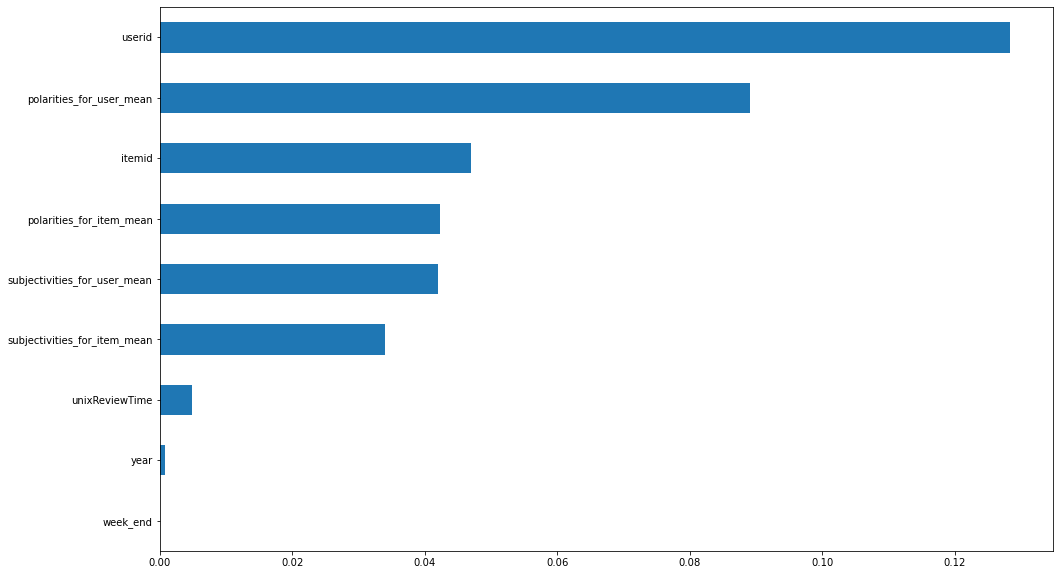

In [11]:
cols = ['unixReviewTime','userid','itemid','year','week_end','subjectivities_for_item_mean',
        'polarities_for_item_mean','subjectivities_for_user_mean','polarities_for_user_mean'] 

imp_cat = Series(mutual_info_classif(df_train[cols], 
                                     df_train['rating'], discrete_features =True), 
                 index = cols)
imp_cat.sort_values(inplace = True)
plt.figure(figsize=(16, 10))
imp_cat.plot(kind = 'barh')

Как было отмечено выше, несмотря на высокую значимость средних значений полярности и средних значений субъективности, они не дали прироста качеству модели. К тому же была высокая степень корреляции (ковариация) с признаками userid и itemid

<AxesSubplot:>

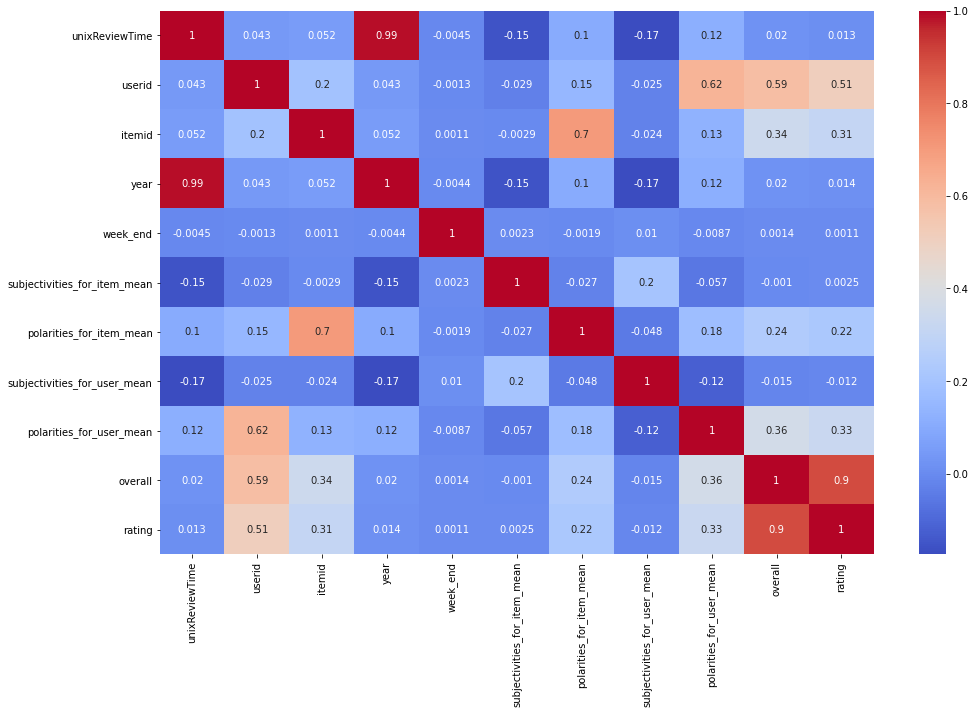

In [12]:
# составляем корреляционную матрица признаков

df_train_corr = df_train[['unixReviewTime','userid','itemid','year','week_end','subjectivities_for_item_mean',
        'polarities_for_item_mean','subjectivities_for_user_mean','polarities_for_user_mean','overall','rating']]

corr_scoring = df_train_corr.corr()
plt.figure(figsize=(16, 10)) # увеличиваем размер теповой карты
sns.heatmap(corr_scoring, annot=True, cmap='coolwarm')

In [13]:
# делим датасет на обучающую часть и тренировочную

train_data, test_data = train_test_split(df_train,random_state=32, shuffle=True)


In [14]:
# делаем матричное разложение

ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'].astype(int),
                                  train_data['itemid'].astype(int))))

In [15]:
NUM_THREADS = 4 #число потоков
NUM_COMPONENTS = 30 #число параметров вектора 
NUM_EPOCHS = 20 #число эпох обучения

model = LightFM(learning_rate=0.1, loss='logistic',
                no_components=NUM_COMPONENTS)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)

In [16]:
preds = model.predict(test_data.userid.values,
                      test_data.itemid.values)

In [17]:
preds.min(), preds.max()

(-9.743284, 18.921383)

In [18]:
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()

In [19]:
normalized_preds.min(), normalized_preds.max()

(0.0, 1.0)

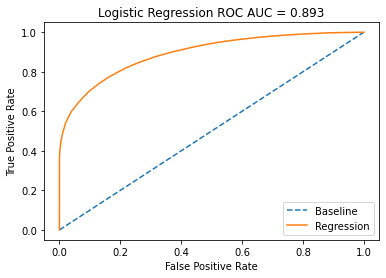

In [20]:
# метрики качества модели 
fpr, tpr, threshold = roc_curve(test_data.rating, normalized_preds)
roc_auc = roc_auc_score(test_data.rating, normalized_preds)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()


In [21]:
y_pred = np.round(normalized_preds) # округленные значения ухудшают результат обучения. 
target_names = ['class 0', 'class 1']
print(classification_report(test_data.rating, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.23      1.00      0.37     32626
     class 1       1.00      0.40      0.57    181848

    accuracy                           0.49    214474
   macro avg       0.61      0.70      0.47    214474
weighted avg       0.88      0.49      0.54    214474



Модель чаще рекомендует товар, чем не рекомендует. 
Для "холодного" клиента можно применить подход рекомендации товара, имеющего высокие показатели среднего рейтинга, а дальше адаптироваться под предпочтения покупателя

Теперь применим полученную модель к тестовому датасету

In [22]:
# поскольку в тестовом датасете имеются items (немного, всего 18 штук), которых нет в тренировочном датасете, таким 
# items для целей применения модели были даны средние значения 5-бального рейтинга, умноженного на 10

a = df_train.overall.mean()
b = {35193:a, 29382:a, 6265:a, 6500:a, 33885:a, 23183:a, 35331:a, 34321:a, 5187:a, 32861:a, 38860:a, 2513:a,
    38890:a, 2398:a, 6564:a, 39031:a, 39019:a, 38875:a} # числовые значения в этом словаре - это и есть 
# отсутствующие itemid в тренировочном датасете, выявленные вручную. Можно их было выявить и автоматически, 
# как это было сделано ниже с userid

dict_itemid_mean.update(b) # добавили в первоначальный словарь словарь b

In [23]:
# поскольку расхождение в количестве userid в тренировочном и тестовом датасетах заметно больше, чем 
# в количестве itemid (48 штук), будем добавлять усредненные значения автоматически, а не вручную

test_users_id = test['userid'].values
train_users_id = df_train['user_id'].values

d = {}
for i in test_users_id:
    if i not in train_users_id:
        c = {i:a}
        d.update(c)

dict_userid_mean.update(d)

In [24]:
# обрабатываем колонки под обучающую модель по аналогии с тем, как это было сделано в тренировочной модели

test['itemid'] = test.itemid.apply(lambda x: dict_itemid_mean[x])
test['userid'] = test.userid.apply(lambda x: dict_userid_mean[x])

In [25]:
preds_test = model.predict(test.userid.values,
                      test.itemid.values)

In [26]:
preds_test.min(), preds_test.max()


(-9.743284, 18.921383)

In [27]:
normalized_preds_test = (preds_test - preds_test.min())/(preds_test - preds_test.min()).max()

In [28]:
normalized_preds_test.min(), normalized_preds_test.max()

(0.0, 1.0)

In [29]:
submission['rating']= normalized_preds_test

In [30]:
submission.to_csv('submission_log.csv', index=False)